In [ ]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.2 MB/s eta 0:00:00


In [ ]:
pip install xgboost==1.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 MB 5.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import math


from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             fbeta_score, roc_curve, roc_auc_score, precision_recall_curve,
                             auc, average_precision_score, classification_report)

import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [ ]:
# Загрузка данных
df_preprocessing = pd.read_csv('/srv/kag_risk_factors_cervical_cancer.csv')
df_preprocessing.shape

(858, 36)

In [ ]:
x = df_preprocessing.drop(columns=['Citology'])  # Замените 'Citology' на имя целевого столбца
y = df_preprocessing['Citology']

x = x.apply(pd.to_numeric, errors='coerce').fillna(0)

Ранее при анализе данных мы выявили проблему несбалансированности классов в целевой переменной. Это может негативно повлиять на качество обучения модели, так как алгоритмы машинного обучения зачастую склонны игнорировать меньшинство классов в пользу более представленных. Чтобы повысить эффективность модели и сделать её более устойчивой к дисбалансу данных, мы начнем работу с устранения этой проблемы. Наши дальнейшие шаги будут направлены на балансировку классов, что позволит модели учитывать важность каждого класса в данных.

Распределение классов:
Класс 0: 814 записей
Класс 1: 44 записей


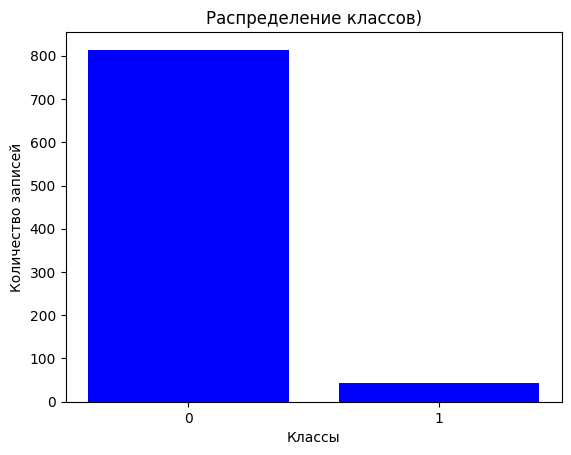

In [ ]:
# Подсчёт количества элементов в каждом классе
class_counts = Counter(y)  # y — это целевая переменная (столбец с метками классов)

print("Распределение классов:")
for label, count in class_counts.items():
    print(f"Класс {label}: {count} записей")

# Визуализация
import matplotlib.pyplot as plt

plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.title('Распределение классов)')
plt.xlabel('Классы')
plt.ylabel('Количество записей')
plt.xticks([0, 1])
plt.show()

In [ ]:
df_preprocessing.replace('?', pd.NA, inplace=True)
df_preprocessing = df_preprocessing.apply(pd.to_numeric)

In [ ]:
# Проверка распределения классов до SMOTE
print("До балансировки методом SMOTE:", Counter(y))

# Применение SMOTE
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

# Проверка распределения классов после SMOTE
print("После балансировии методом SMOTE:", Counter(y_resampled))

#Соберем файл
resampled_data = pd.concat([pd.DataFrame(x_resampled), pd.Series(y_resampled, name='Citology')], axis=1)

До балансировки методом SMOTE: Counter({0: 814, 1: 44})
После балансировии методом SMOTE: Counter({0: 814, 1: 814})


In [ ]:
#Избавимся от столбцов, которые содержат одни пропуски
resampled_data = resampled_data.drop(columns=['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis', 'STDs:AIDS'])
#Ввиду обобщающего характера признаков и предположении о дальнейшем использовании для опроса было принятно решение избавиться сразу от еще нескольких столбцов.
#Удалим столбцы, которые не являются информативными для дальнейшего анализа: для признака, характеризующего паппиломы, взят общий признак наличие паппилом, для курения - стаж.
resampled_data = resampled_data.drop(columns=['STDs: Number of diagnosis', 'STDs (number)', 'STDs', 'Dx',  'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:cervical condylomatosis', 'Smokes (packs/year)', 'Biopsy'])

In [ ]:
# Список столбцов для округления и точности округления
columns_to_round = {
    'Number of sexual partners': 0,
    'First sexual intercourse': 0,
    'Num of pregnancies': 0,
    'Smokes': 0,
    'Hormonal Contraceptives': 0,
    'Hormonal Contraceptives (years)': 2,
    'IUD': 0,
    'IUD (years)': 2,
    'STDs:condylomatosis': 0,
    'STDs:syphilis': 0,
    'STDs:pelvic inflammatory disease': 0,
    'STDs:genital herpes': 0,
    'STDs:molluscum contagiosum': 0,
    'STDs:HIV': 0,
    'STDs:Hepatitis B': 0,
    'STDs:HPV': 0
}

# Цикл для обработки столбцов
for column, decimals in columns_to_round.items():
    if column in resampled_data.columns:
        resampled_data[column] = resampled_data[column].round(decimals)

In [ ]:
df = resampled_data
df.shape

(1628, 24)

In [ ]:
#Изучим набор данных
df.info()
df.head(5)
missing_values = df.isnull().sum()
missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1628 entries, 0 to 1627
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               1628 non-null   int64  
 1   Number of sexual partners         1628 non-null   float64
 2   First sexual intercourse          1628 non-null   float64
 3   Num of pregnancies                1628 non-null   float64
 4   Smokes                            1628 non-null   float64
 5   Smokes (years)                    1628 non-null   float64
 6   Hormonal Contraceptives           1628 non-null   float64
 7   Hormonal Contraceptives (years)   1628 non-null   float64
 8   IUD                               1628 non-null   float64
 9   IUD (years)                       1628 non-null   float64
 10  STDs:condylomatosis               1628 non-null   float64
 11  STDs:syphilis                     1628 non-null   float64
 12  STDs:p

,0
Age,0
Number of sexual partners,0
First sexual intercourse,0
Num of pregnancies,0
Smokes,0
Smokes (years),0
Hormonal Contraceptives,0
Hormonal Contraceptives (years),0
IUD,0
IUD (years),0


In [ ]:
#Приведем формат данных в читабельный вид.
df = df.astype('int64')
pd.set_option('display.float_format', lambda x: '%0.4f' % x)

In [ ]:
df.to_csv('resampled_data.csv', index=False)

Построим ML модель на исходных данных (1)

In [ ]:
df_for_ml_all = df.copy()
df_for_ml_all.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs:condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:HIV', 'STDs:Hepatitis B',
       'STDs:HPV', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Hinselmann', 'Schiller',
       'Citology'],
      dtype='object')

In [ ]:
#Разделим данные на тренировочные и тестовые в соотношении 70/30. Такое соотношение обусловлено размеров датасета. В качестве результатирующего выбран признак "Citology ":
x = df_for_ml_all.drop('Citology', axis=1)
y = df_for_ml_all['Citology']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
#Опишем, какие данные относятся к числовым, какие - к бинарным:

numeric_features = ['Age', 'Number of sexual partners',
                    'First sexual intercourse',
                    'Num of pregnancies',
                    'Smokes (years)',
                    'Hormonal Contraceptives (years)',
                    'IUD (years)']

binary_features = ['Smokes','Hormonal Contraceptives', 'IUD',
                   'STDs:condylomatosis', 'STDs:syphilis',
                   'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
                   'STDs:molluscum contagiosum', 'STDs:HIV', 'STDs:Hepatitis B',
                   'STDs:HPV',
                   'Dx:Cancer', 'Dx:CIN', 'Dx:HPV',
                   'Hinselmann', 'Schiller']
# Стандартизируем числовые признаки:
scaler = StandardScaler()
x_train_numeric = scaler.fit_transform(x_train[numeric_features])
x_test_numeric = scaler.transform(x_test[numeric_features])

# Преобразуем данные в улдобный вид:
x_train_numeric_df = pd.DataFrame(x_train_numeric, columns=numeric_features)
x_test_numeric_df = pd.DataFrame(x_test_numeric, columns=numeric_features)

# Бинарные признаки могут оставаться без стандартизации, поэтому оставляем их в исходном виде:
x_train_binary_df = x_train[binary_features].reset_index(drop=True)
x_test_binary_df = x_test[binary_features].reset_index(drop=True)

# Объединение стандартизированных числовых и бинарных признаков
x_train_scaled_for_all = pd.concat([x_train_numeric_df, x_train_binary_df], axis=1)
x_test_scaled_for_all = pd.concat([x_test_numeric_df, x_test_binary_df], axis=1)

#Отберем алгоритмы, которые показали эффективность в предыдущих исследованиях
classifiers = {
"Logistic Regression": LogisticRegression(random_state=42),
"Random_Forest": RandomForestClassifier(random_state=42),

"AdaBoost": AdaBoostClassifier(random_state=42),
"Gradient Boosting": GradientBoostingClassifier(random_state=42),
"XGBoost": XGBClassifier(random_state=42),
"CatBoost": CatBoostClassifier(verbose=0,random_state=42),

"K-Nearest Neighbors": KNeighborsClassifier(),
"Support Vector Machine": SVC(random_state=42),
"Gradient Boosting": GradientBoostingClassifier(random_state=42),
"Naive Bayes": GaussianNB(),
"Decision Tree": DecisionTreeClassifier(random_state=42)
}

results = {}
for name, classifier in classifiers.items():
  classifier.fit(x_train_scaled_for_all, y_train) # Обучение модели
  y_pred_for_all = classifier.predict(x_test_scaled_for_all) # Предсказание на тестовой выборке
  accuracy = accuracy_score(y_test, y_pred_for_all) # Оценка точности
  precision = precision_score(y_test, y_pred_for_all)
  recall = recall_score(y_test, y_pred_for_all)
  f1 = f1_score(y_test, y_pred_for_all)

  print(f"{name} Accuracy: {accuracy:.3f}, Precision: {precision:.3f},  Recall: {recall:.3f}, F1: {f1:.3f}")


Logistic Regression Accuracy: 0.691, Precision: 0.672,  Recall: 0.736, F1: 0.702
Random_Forest Accuracy: 0.898, Precision: 0.864,  Recall: 0.942, F1: 0.901
AdaBoost Accuracy: 0.753, Precision: 0.720,  Recall: 0.818, F1: 0.766
Gradient Boosting Accuracy: 0.855, Precision: 0.811,  Recall: 0.921, F1: 0.863
XGBoost Accuracy: 0.902, Precision: 0.873,  Recall: 0.938, F1: 0.904
CatBoost Accuracy: 0.877, Precision: 0.823,  Recall: 0.959, F1: 0.885
K-Nearest Neighbors Accuracy: 0.851, Precision: 0.779,  Recall: 0.975, F1: 0.866
Support Vector Machine Accuracy: 0.812, Precision: 0.748,  Recall: 0.934, F1: 0.831
Naive Bayes Accuracy: 0.513, Precision: 0.504,  Recall: 1.000, F1: 0.670
Decision Tree Accuracy: 0.845, Precision: 0.817,  Recall: 0.884, F1: 0.849


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score

#Разделим данные на тренировочные и тестовые в соотношении 70/30
x = df_for_ml_all.drop('Citology', axis=1)
y = df_for_ml_all['Citology']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

numeric_features = ['Age', 'Number of sexual partners',
                    'First sexual intercourse',
                    'Num of pregnancies',
                    'Smokes (years)',
                    'Hormonal Contraceptives (years)',
                    'IUD (years)']

binary_features = ['Smokes','Hormonal Contraceptives', 'IUD',
                   'STDs:condylomatosis', 'STDs:syphilis',
                   'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
                   'STDs:molluscum contagiosum', 'STDs:HIV', 'STDs:Hepatitis B',
                   'STDs:HPV',
                   'Dx:Cancer', 'Dx:CIN', 'Dx:HPV',
                   'Hinselmann', 'Schiller']

# Стандартизируем числовые признаки:
scaler = StandardScaler()
x_train_numeric = scaler.fit_transform(x_train[numeric_features])
x_test_numeric = scaler.transform(x_test[numeric_features])

# Преобразуем данные в улдобный вид:
x_train_numeric_df = pd.DataFrame(x_train_numeric, columns=numeric_features)
x_test_numeric_df = pd.DataFrame(x_test_numeric, columns=numeric_features)

# Бинарные признаки могут оставаться без стандартизации, поэтому оставляем их в исходном виде:
x_train_binary_df = x_train[binary_features].reset_index(drop=True)
x_test_binary_df = x_test[binary_features].reset_index(drop=True)

# Объединение стандартизированных числовых и бинарных признаков
x_train_scaled_for_all_neural  = pd.concat([x_train_numeric_df, x_train_binary_df], axis=1)
x_test_scaled_for_all_neural  = pd.concat([x_test_numeric_df, x_test_binary_df], axis=1)



# Создание нейронной сети
model = Sequential()

# Первый скрытый слой
model.add(Dense(64, input_dim=x_train_scaled_for_all_neural.shape[1], activation='relu'))
model.add(Dropout(0.3))  # Dropout для регуляризации

# Второй скрытый слой
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# Выходной слой
# Используем "sigmoid" для бинарной классификации
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Обучение модели
history = model.fit(x_train_scaled_for_all_neural,
                    y_train,  # Используем целевые значения как есть
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

# Оценка модели
loss, accuracy = model.evaluate(x_test_scaled_for_all_neural, y_test, verbose=0)
print(f"Accuracy: {accuracy:.3f}, Precision: {precision:.3f},  Recall: {recall:.3f}, F1: {f1:.3f}")


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5607 - loss: 0.6867 - val_accuracy: 0.6096 - val_loss: 0.6613
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6102 - loss: 0.6669 - val_accuracy: 0.6667 - val_loss: 0.6454
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6152 - loss: 0.6556 - val_accuracy: 0.6842 - val_loss: 0.6312
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6776 - loss: 0.6209 - val_accuracy: 0.7018 - val_loss: 0.6129
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7000 - loss: 0.5992 - val_accuracy: 0.6974 - val_loss: 0.5951
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6898 - loss: 0.5923 - val_accuracy: 0.7061 - val_loss: 0.5788
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7181 - loss: 0.5688 - val_accuracy: 0.7193 - val_loss: 0.5643
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7032 - loss: 0.5517 - val_accuracy: 0.7325 - val_loss:

**PCA**

---



Одним из популярных способ снижения признакового пространства является метод главных компонент. Суть метода главных компонент (Principal Component Analysis, PCA) заключается именно преобразовании коррелируемых признаков в новый набор некоррелируемых признаков, называемых главными компонентами.

In [ ]:
df_for_pca = df.copy()

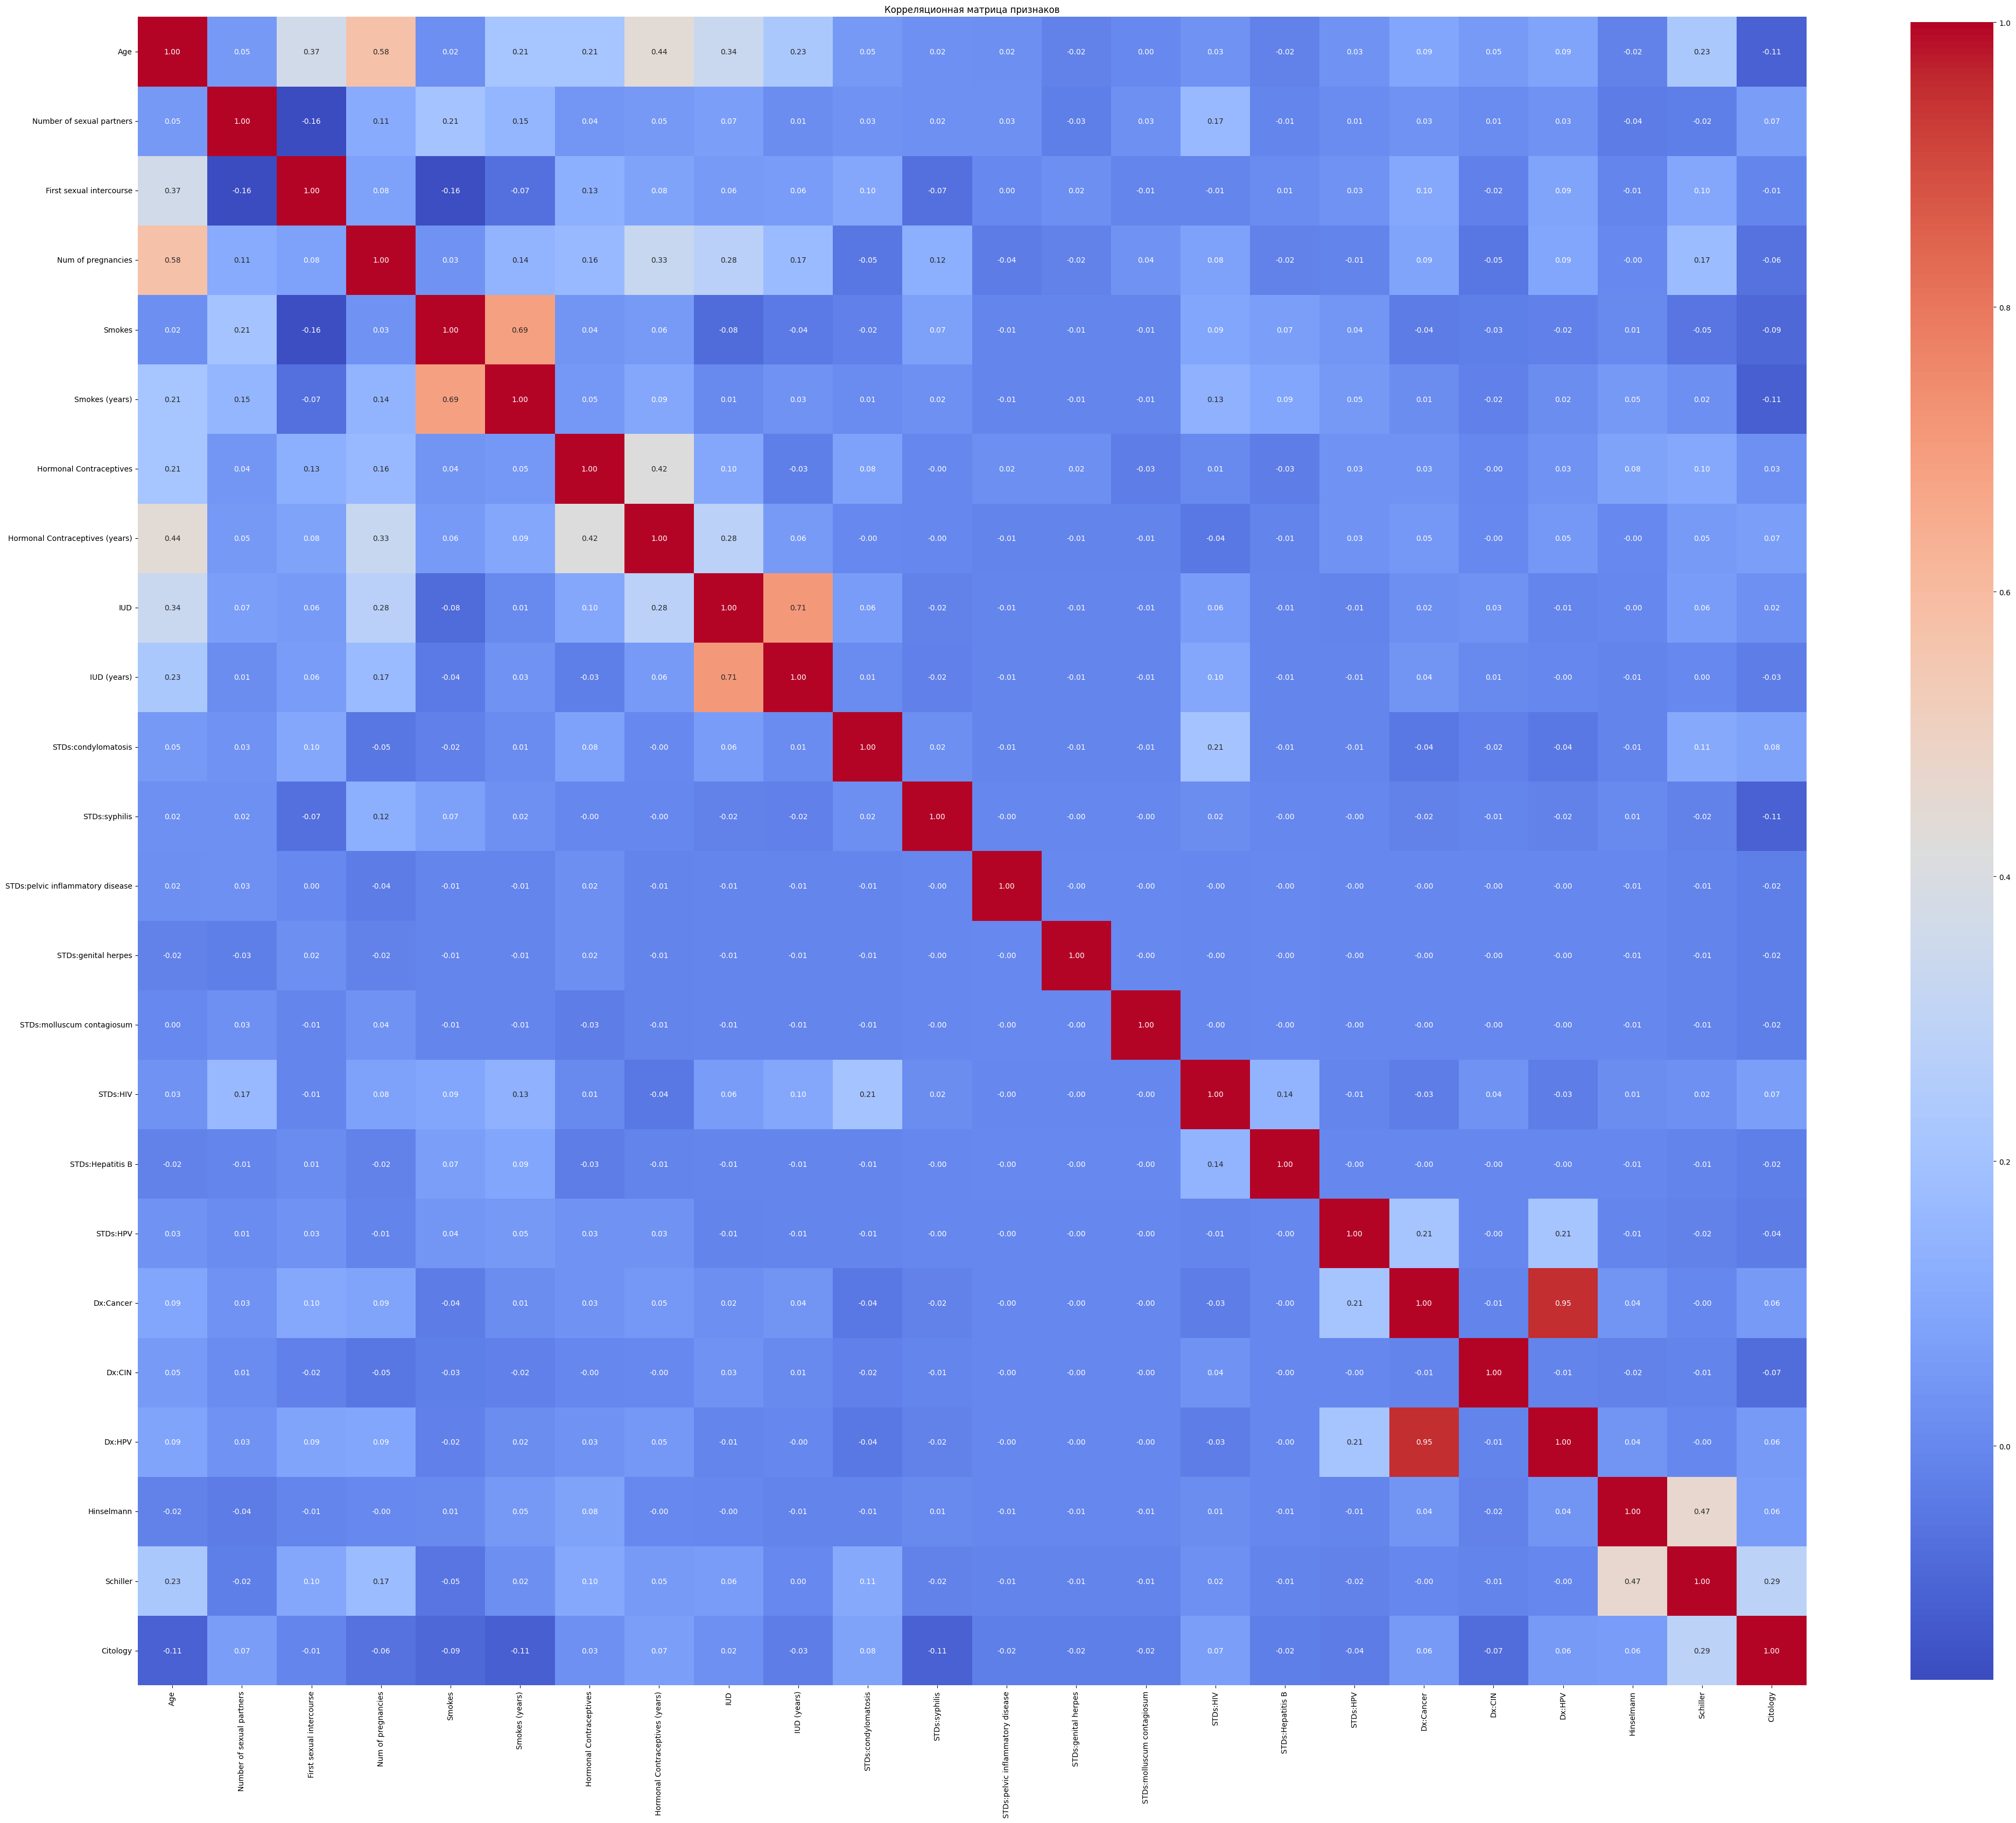

In [ ]:
# Вычисляем корреляцию между признаками по очищенному набору данных
correlation_matrix = df_for_pca.corr()

# Построим тепловую карту
plt.figure(figsize=(50, 50))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Корреляционная матрица признаков')
plt.show()



По корреляционной матрцие проведем анализ признаков и оставим те признаки, которые могут внести вклад в компоненты.

In [ ]:
df_for_pca = df_for_pca.drop(columns=[
                      'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum',
                      'STDs:syphilis', 'Dx:CIN', 'Number of sexual partners', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV'])

In [ ]:
df_for_pca.columns

Index(['Age', 'First sexual intercourse', 'Num of pregnancies', 'Smokes',
       'Smokes (years)', 'Hormonal Contraceptives',
       'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)',
       'STDs:condylomatosis', 'Dx:Cancer', 'Dx:HPV', 'Hinselmann', 'Schiller',
       'Citology'],
      dtype='object')

Сформируем датафрейм признаков для дальнейшего анализа:

In [ ]:
df_pca = df_for_pca[['Age', 'First sexual intercourse', 'Num of pregnancies', 'Smokes',
       'Smokes (years)', 'Hormonal Contraceptives',
       'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)',
       'STDs:condylomatosis', 'Dx:Cancer', 'Dx:HPV', 'Hinselmann', 'Schiller',
       'Citology']]

In [ ]:
#Разделим данные на тренировочные и тестовые в соотношении 70/30
from sklearn.model_selection import train_test_split
x = df_pca.drop('Citology', axis=1)
y = df_pca['Citology']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
numeric_features = ['Age', 'First sexual intercourse', 'Num of pregnancies', 'Smokes (years)',
     'Hormonal Contraceptives (years)',  'IUD (years)']
binary_features = ['Smokes',
       'Hormonal Contraceptives','IUD' , 'STDs:condylomatosis', 'Dx:HPV', 'Dx:Cancer',  'Hinselmann', 'Schiller']

# Стандартизация числовых признаков
scaler = StandardScaler()
x_train_numeric = scaler.fit_transform(x_train[numeric_features])
x_test_numeric = scaler.transform(x_test[numeric_features])

# Преобразование в DataFrame
x_train_numeric_df = pd.DataFrame(x_train_numeric, columns=numeric_features)
x_test_numeric_df = pd.DataFrame(x_test_numeric, columns=numeric_features)

# Бинарные признаки остаются без изменений
x_train_binary_df = x_train[binary_features].reset_index(drop=True)
x_test_binary_df = x_test[binary_features].reset_index(drop=True)

# Объединение стандартизированных числовых и бинарных признаков
x_train_scaled_pca = pd.concat([x_train_numeric_df, x_train_binary_df], axis=1)
x_test_scaled_pca = pd.concat([x_test_numeric_df, x_test_binary_df], axis=1)

In [ ]:
pca_test = PCA(n_components=13)
pca_test.fit(x_train_scaled_pca)
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
eigenvalues = pca_test.explained_variance_
eigenvalues_df = pd.DataFrame(eigenvalues, columns=['Собственные значения'])
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
pca_df['eigenvalue'] = eigenvalues_df

pd.set_option('display.float_format', lambda x: '%0.4f' % x)
display(pca_df.head(15))

,Cumulative Variance Ratio,Explained Variance Ratio,eigenvalue
0,0.3210,0.3210,2.1636
1,0.4898,0.1688,1.1379
2,0.6388,0.1490,1.0040
3,0.7685,0.1297,0.8744
4,0.8670,0.0985,0.6641
5,0.9155,0.0485,0.3270
6,0.9443,0.0287,0.1935
7,0.9654,0.0211,0.1425
8,0.9750,0.0096,0.0646
9,0.9832,0.0082,0.0554


Построим график метода локтя:

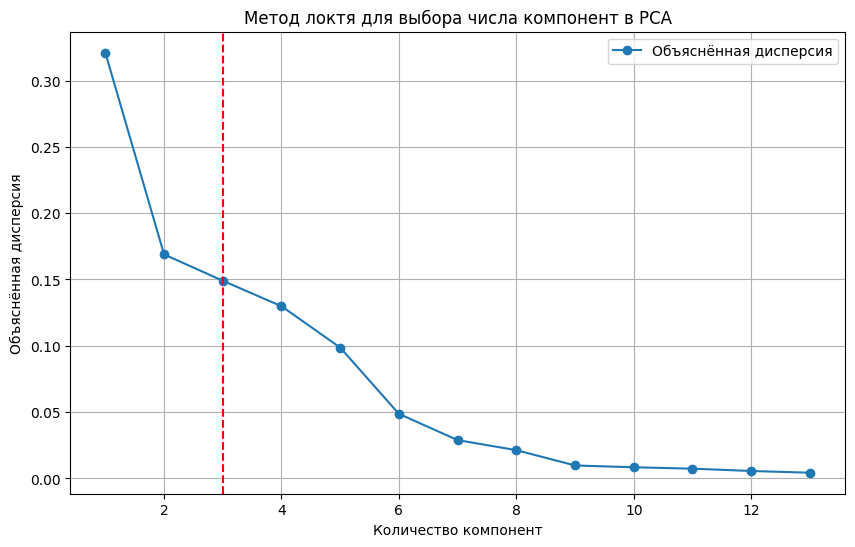

In [ ]:
explained_variance = pca_test.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Объяснённая дисперсия')
plt.title('Метод локтя для выбора числа компонент в PCA')
plt.xlabel('Количество компонент')
plt.ylabel('Объяснённая дисперсия')
plt.axvline(x=3, color='r', linestyle='--') # Пример линии для показания "локтя"
plt.legend()
plt.grid()
plt.show()

Изучим главные компоненты и вклад признаков в каждую. В процессе работы на МГК были удалены еще два признака, которые имели нулевые доли.

In [ ]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns= x_train_scaled_pca.columns, index=pca_dims)
pca_test_df[['Age', 'First sexual intercourse', 'Num of pregnancies', 'Smokes',
       'Smokes (years)', 'Hormonal Contraceptives',
       'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'Dx:Cancer',
       'Dx:HPV', 'Hinselmann', 'Schiller']].head(4)

,Age,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),Dx:Cancer,Dx:HPV,Hinselmann,Schiller
PCA Component 0,0.5956,0.2514,0.5227,0.0302,0.2321,0.1120,0.4173,0.0881,0.2394,0.0137,0.0130,-0.0008,0.0442
PCA Component 1,-0.0833,-0.6148,0.1074,0.1767,0.6845,0.0092,0.1366,-0.0588,-0.2843,-0.0070,-0.0042,0.0148,-0.0165
PCA Component 2,-0.0706,-0.3918,0.1058,0.0085,0.0432,-0.1110,-0.3028,0.1549,0.8369,-0.0022,-0.0054,0.0010,-0.0034
PCA Component 3,-0.1208,-0.4998,0.1462,-0.1103,-0.5795,0.1119,0.5913,0.0476,-0.0120,-0.0079,-0.0067,-0.0152,-0.0305


Обучим модель, которую удалось выявить в процессе МГК

In [ ]:
df_for_pca = df[['Age', 'First sexual intercourse', 'Num of pregnancies', 'Smokes',
       'Smokes (years)', 'Hormonal Contraceptives',
       'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'Dx:Cancer',
       'Dx:HPV', 'Hinselmann', 'Schiller','Citology']]

In [ ]:
#Разделим данные на тренировочные и тестовые в соотношении 70/30
x = df_for_pca.drop('Citology', axis=1)
y = df_for_pca['Citology']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
numeric_features = ['Age', 'First sexual intercourse', 'Num of pregnancies', 'Smokes (years)',
     'Hormonal Contraceptives (years)',  'IUD (years)']
binary_features = ['Smokes',
       'Hormonal Contraceptives','IUD' , 'Dx:HPV', 'Dx:Cancer',  'Hinselmann', 'Schiller']

# Стандартизация числовых признаков
scaler = StandardScaler()
x_train_numeric = scaler.fit_transform(x_train[numeric_features])
x_test_numeric = scaler.transform(x_test[numeric_features])

# Преобразование в DataFrame
x_train_numeric_df = pd.DataFrame(x_train_numeric, columns=numeric_features)
x_test_numeric_df = pd.DataFrame(x_test_numeric, columns=numeric_features)

# Бинарные признаки остаются без изменений
x_train_binary_df = x_train[binary_features].reset_index(drop=True)
x_test_binary_df = x_test[binary_features].reset_index(drop=True)

# Объединение стандартизированных числовых и бинарных признаков
x_train_scaled_for_pca = pd.concat([x_train_numeric_df, x_train_binary_df], axis=1)
x_test_scaled_for_pca = pd.concat([x_test_numeric_df, x_test_binary_df], axis=1)

In [ ]:
pca = PCA(n_components=4)
pca.fit(x_train_scaled_for_pca)
x_train_scaled_pca = pca.transform(x_train_scaled_for_pca)
x_test_scaled_pca = pca.transform(x_test_scaled_for_pca)

In [ ]:
#Отберем алгоритмы, которые показали эффективность в предыдущих исследованиях
classifiers = {
"Logistic Regression": LogisticRegression(random_state=42),
"Random_Forest": RandomForestClassifier(random_state=42),
"AdaBoost": AdaBoostClassifier(random_state=42),
"Gradient Boosting": GradientBoostingClassifier(random_state=42),
"XGBoost": XGBClassifier(random_state=42),
"CatBoost": CatBoostClassifier(verbose=0, random_state=42),
"K-Nearest Neighbors": KNeighborsClassifier(),
"Support Vector Machine": SVC(random_state=42),
"Naive Bayes": GaussianNB(),
"Decision Tree": DecisionTreeClassifier()
}


results = {}
for name, classifier in classifiers.items():
  classifier.fit(x_train_scaled_pca, y_train) # Обучение модели
  y_pred_pca = classifier.predict(x_test_scaled_pca) # Предсказание на тестовой выборке
  accuracy = accuracy_score(y_test, y_pred_pca) # Оценка точности
  precision = precision_score(y_test, y_pred_pca)
  recall = recall_score(y_test, y_pred_pca)
  f1 = f1_score(y_test, y_pred_pca)
  print(f"{name} Accuracy: {accuracy:.3f}, Precision: {precision:.3f},  Recall: {recall:.3f}, F1: {f1:.3f}")

Logistic Regression Accuracy: 0.571, Precision: 0.550,  Recall: 0.731, F1: 0.628
Random_Forest Accuracy: 0.826, Precision: 0.808,  Recall: 0.851, F1: 0.829
AdaBoost Accuracy: 0.648, Precision: 0.614,  Recall: 0.777, F1: 0.686
Gradient Boosting Accuracy: 0.738, Precision: 0.704,  Recall: 0.814, F1: 0.755
XGBoost Accuracy: 0.804, Precision: 0.774,  Recall: 0.851, F1: 0.811
CatBoost Accuracy: 0.779, Precision: 0.754,  Recall: 0.822, F1: 0.787
K-Nearest Neighbors Accuracy: 0.763, Precision: 0.720,  Recall: 0.851, F1: 0.780
Support Vector Machine Accuracy: 0.638, Precision: 0.586,  Recall: 0.917, F1: 0.715
Naive Bayes Accuracy: 0.546, Precision: 0.526,  Recall: 0.847, F1: 0.649
Decision Tree Accuracy: 0.798, Precision: 0.758,  Recall: 0.868, F1: 0.809


In [ ]:
# Определение параметров для RandomizedSearchCV
param_dist = {
'n_estimators': np.arange(10, 200, 10),
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth': np.arange(1, 20, 1),
'min_samples_split': np.arange(2, 10, 1),
'min_samples_leaf': np.arange(1, 10, 1),
'bootstrap': [True, False]
}

# Настройка RandomizedSearchCV
rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
n_iter=100, cv=3, verbose=2,
random_state=42, n_jobs=-1)

# Обучение на данных
rf_random.fit(x_train_scaled_pca, y_train)
print("Лучшие гиперпараметры:", rf_random.best_params_)

# Оценка
best_rf = rf_random.best_estimator_
y_pred_tst = best_rf.predict(x_test_scaled_pca)
print(classification_report(y_test, y_pred_tst))
print('Accuracy:', accuracy_score(y_test, y_pred_tst))


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Лучшие гиперпараметры: {'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 13, 'bootstrap': False}
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       247
           1       0.79      0.87      0.83       242

    accuracy                           0.82       489
   macro avg       0.82      0.82      0.82       489
weighted avg       0.83      0.82      0.82       489

Accuracy: 0.8220858895705522


FEATURE_IMPORTANCES

Попробуем сократить признаковое пространство с помощью feature_importances. На основе обученной модели RandomForest попробуем выделить важные признаки и проверить, как на такой выборке будут работать модели.

In [ ]:
df_for_ml_fi = df.copy()

In [ ]:
#Разделим данные на тренировочные и тестовые в соотношении 70/30. Такое соотношение обусловлено размеров датасета. В качестве результатирующего выбран признак "Citology ":
x = df_for_ml_fi.drop('Citology', axis=1)
y = df_for_ml_fi['Citology']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#Опишем, какие данные относятся к числовым, какие - к бинарным:
numeric_features = ['Age', 'Number of sexual partners',
                    'First sexual intercourse',
                    'Num of pregnancies',
                    'Smokes (years)',
                    'Hormonal Contraceptives (years)',
                    'IUD (years)']
binary_features = ['Smokes','Hormonal Contraceptives', 'IUD',
                   'STDs:condylomatosis', 'STDs:syphilis',
                   'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
                   'STDs:molluscum contagiosum', 'STDs:HIV', 'STDs:Hepatitis B',
                   'STDs:HPV',
                   'Dx:Cancer', 'Dx:CIN', 'Dx:HPV',
                   'Hinselmann', 'Schiller']
# Стандартизируем числовые признаки:
scaler = StandardScaler()
x_train_numeric = scaler.fit_transform(x_train[numeric_features])
x_test_numeric = scaler.transform(x_test[numeric_features])

# Преобразуем данные в улдобный вид:
x_train_numeric_df = pd.DataFrame(x_train_numeric, columns=numeric_features)
x_test_numeric_df = pd.DataFrame(x_test_numeric, columns=numeric_features)

# Бинарные признаки могут оставаться без стандартизации, поэтому оставляем их в исходном виде:
x_train_binary_df = x_train[binary_features].reset_index(drop=True)
x_test_binary_df = x_test[binary_features].reset_index(drop=True)

# Объединение стандартизированных числовых и бинарных признаков
x_train_scaled = pd.concat([x_train_numeric_df, x_train_binary_df], axis=1)
x_test_scaled = pd.concat([x_test_numeric_df, x_test_binary_df], axis=1)

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train_scaled, y_train)

# Прогнозирование на тестовых данных
rf_predictions = rf_model.predict(x_test_scaled)

# Оценка качества
print('Random Forest:')
print(classification_report(y_test, rf_predictions))
print('Accuracy:', accuracy_score(y_test, rf_predictions))

Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       247
           1       0.88      0.95      0.91       242

    accuracy                           0.91       489
   macro avg       0.91      0.91      0.91       489
weighted avg       0.91      0.91      0.91       489

Accuracy: 0.9120654396728016


Оценем признаки с помощью критерия Джини. Можно отобрать либо те признаки, вклад которых больше 5% от максимального (0,2276) или решить на основании графика.

In [ ]:
feats = {}
for feature, importance in zip(df_for_ml_fi.columns, rf_model.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances.sort_values(by = 'Gini-Importance', ascending=False)

,Gini-Importance
Age,0.2151
First sexual intercourse,0.1531
Number of sexual partners,0.1274
Smokes (years),0.1070
Num of pregnancies,0.0985
Schiller,0.0886
IUD,0.0407
Hormonal Contraceptives,0.0361
Smokes,0.0321
Hormonal Contraceptives (years),0.0195


Визуализируем данные. Отобразим зеленым признаки, которые мы включим в новый датафрейм, красным - те, вклад которых в модель недостаточен (по оценке).

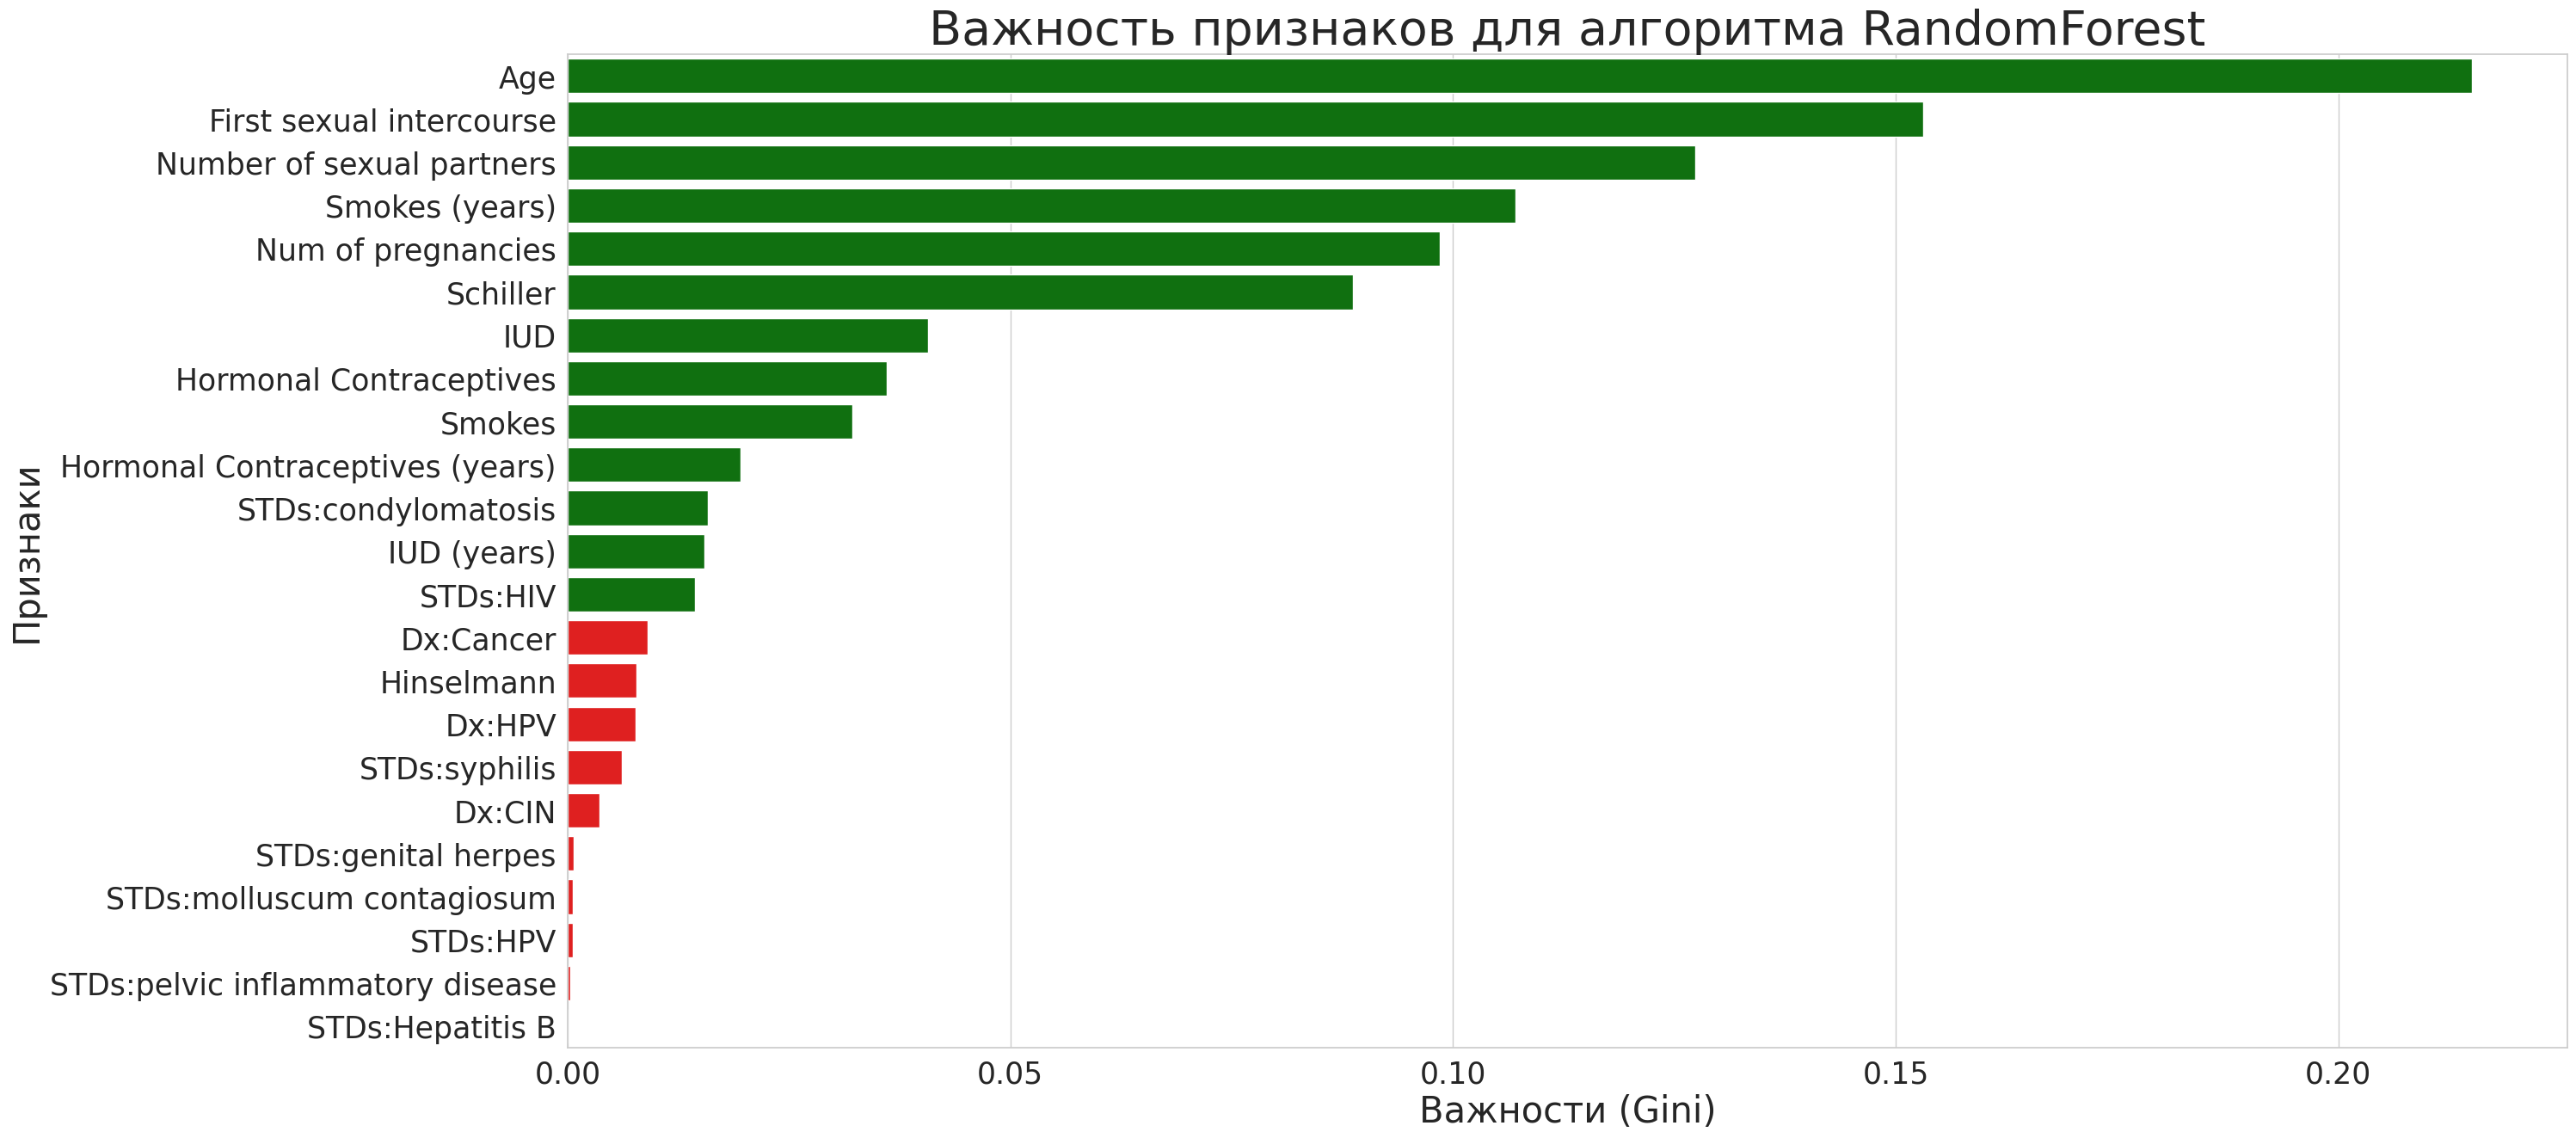

In [ ]:
importances = pd.DataFrame.from_dict(feats, orient='index', columns=['Gini-Importance'])
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(style="whitegrid", color_codes=True, font_scale=1.7)
fig, ax = plt.subplots(figsize=(30, 15))
colors = ['green' if value > 0.01171 else 'red' for value in importances['Gini-Importance']]
sns.barplot(x='Gini-Importance', y='Features', data=importances, palette=colors, ax=ax)
ax.set_title('Важность признаков для алгоритма RandomForest', fontsize=40)
ax.set_xlabel('Важности (Gini)', fontsize=30)
ax.set_ylabel('Признаки', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In [ ]:
df_for_ml1_fi_feat = df_for_ml_fi[['Age', 'Number of sexual partners', 'First sexual intercourse', 'STDs:condylomatosis',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)',
        'IUD',  'IUD (years)', 'STDs:HIV', 'Schiller',
       'Citology']]

Отберем значимые признаки и сформируем новый датасет.

Посмотрим модели на основе новых признаков:

In [ ]:
#Разделим данные на тренировочные и тестовые в соотношении 70/30
x = df_for_ml1_fi_feat.drop('Citology', axis=1)
y = df_for_ml1_fi_feat['Citology']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
numeric_features = ['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes (years)', 'Hormonal Contraceptives (years)', 'IUD (years)' ]
binary_features = ['Hormonal Contraceptives',  'Smokes', 'IUD', 'Schiller', 'STDs:HIV', 'STDs:condylomatosis']

# Стандартизация числовых признаков
scaler = StandardScaler()
x_train_numeric = scaler.fit_transform(x_train[numeric_features])
x_test_numeric = scaler.transform(x_test[numeric_features])

# Преобразование в DataFrame
x_train_numeric_df = pd.DataFrame(x_train_numeric, columns=numeric_features)
x_test_numeric_df = pd.DataFrame(x_test_numeric, columns=numeric_features)

# Бинарные признаки остаются без изменений
x_train_binary_df = x_train[binary_features].reset_index(drop=True)
x_test_binary_df = x_test[binary_features].reset_index(drop=True)

# Объединение стандартизированных числовых и бинарных признаков
x_train_scaled_fi = pd.concat([x_train_numeric_df, x_train_binary_df], axis=1)
x_test_scaled_fi = pd.concat([x_test_numeric_df, x_test_binary_df], axis=1)

In [ ]:
#Отберем аналогичные алгоритмы

classifiers = {
"Logistic Regression": LogisticRegression(),
"Random_Forest": RandomForestClassifier(),
"AdaBoost": AdaBoostClassifier(),
"Gradient Boosting": GradientBoostingClassifier(),
"XGBoost": XGBClassifier(),
"CatBoost": CatBoostClassifier(verbose=0),
"K-Nearest Neighbors": KNeighborsClassifier(),
"Support Vector Machine": SVC(),
"Gradient Boosting": GradientBoostingClassifier(),
"AdaBoost": AdaBoostClassifier(),
"Naive Bayes": GaussianNB(),
"Decision Tree": DecisionTreeClassifier()
}


results = {}
for name, classifier in classifiers.items():
  classifier.fit(x_train_scaled_fi, y_train) # Обучение модели
  y_pred_fi= classifier.predict(x_test_scaled_fi) # Предсказание на тестовой выборке
  accuracy = accuracy_score(y_test, y_pred_fi) # Оценка точности
  precision = precision_score(y_test, y_pred_fi)
  recall = recall_score(y_test, y_pred_fi)
  f1 = f1_score(y_test, y_pred_fi)

  print(f"{name} Accuracy: {accuracy:.3f}, Precision: {precision:.3f},  Recall: {recall:.3f}, F1: {f1:.3f}")

Logistic Regression Accuracy: 0.681, Precision: 0.667,  Recall: 0.711, F1: 0.688
Random_Forest Accuracy: 0.910, Precision: 0.884,  Recall: 0.942, F1: 0.912
AdaBoost Accuracy: 0.734, Precision: 0.699,  Recall: 0.814, F1: 0.752
Gradient Boosting Accuracy: 0.855, Precision: 0.804,  Recall: 0.934, F1: 0.864
XGBoost Accuracy: 0.894, Precision: 0.863,  Recall: 0.934, F1: 0.897
CatBoost Accuracy: 0.883, Precision: 0.827,  Recall: 0.967, F1: 0.891
K-Nearest Neighbors Accuracy: 0.859, Precision: 0.789,  Recall: 0.975, F1: 0.872
Support Vector Machine Accuracy: 0.798, Precision: 0.734,  Recall: 0.926, F1: 0.819
Naive Bayes Accuracy: 0.685, Precision: 0.637,  Recall: 0.847, F1: 0.727
Decision Tree Accuracy: 0.847, Precision: 0.822,  Recall: 0.880, F1: 0.850


In [ ]:
# Определение параметров для RandomizedSearchCV
param_dist = {
'n_estimators': np.arange(10, 200, 10),
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth': np.arange(1, 20, 1),
'min_samples_split': np.arange(2, 10, 1),
'min_samples_leaf': np.arange(1, 10, 1),
'bootstrap': [True, False]
}

# Настройка RandomizedSearchCV
rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
n_iter=100, cv=3, verbose=2,
random_state=42, n_jobs=-1)

# Обучение на данных
rf_random.fit(x_train_scaled_fi, y_train)
print("Лучшие гиперпараметры:", rf_random.best_params_)

# Оценка
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(x_test_scaled_fi)
print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Лучшие гиперпараметры: {'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 13, 'bootstrap': False}
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       247
           1       0.84      0.95      0.89       242

    accuracy                           0.88       489
   macro avg       0.89      0.88      0.88       489
weighted avg       0.89      0.88      0.88       489

Accuracy: 0.8834355828220859


ПРИМЕР ДЛЯ SFS

Отобранные признаки и точность на каждом этапе:
Количество признаков: 1
Признаки: ('Schiller',)
Средняя точность: 0.6058
----------------------------------------
Количество признаков: 2
Признаки: ('Age', 'Schiller')
Средняя точность: 0.6409
----------------------------------------
Количество признаков: 3
Признаки: ('Age', 'First sexual intercourse', 'Schiller')
Средняя точность: 0.7050
----------------------------------------
Количество признаков: 4
Признаки: ('Age', 'Number of sexual partners', 'First sexual intercourse', 'Schiller')
Средняя точность: 0.7832
----------------------------------------
Количество признаков: 5
Признаки: ('Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Schiller')
Средняя точность: 0.8349
----------------------------------------
Количество признаков: 6
Признаки: ('Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Hormonal Contraceptives', 'Schiller')
Средняя точность: 0.8551
---------

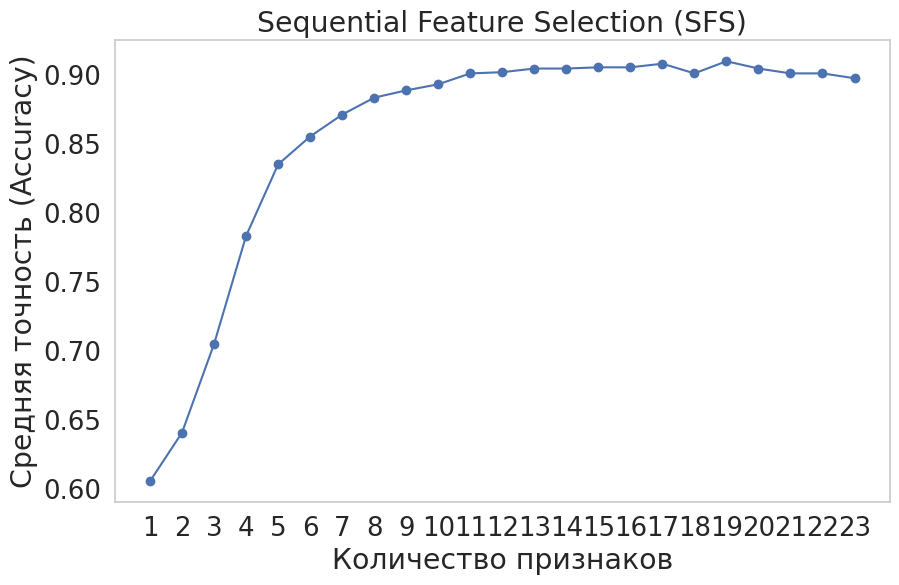

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split

#Разделим данные на тренировочные и тестовые в соотношении 70/30. Такое соотношение обусловлено размеров датасета. В качестве результатирующего выбран признак "Citology ":
x = df_for_ml_all.drop('Citology', axis=1)
y = df_for_ml_all['Citology']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
#Опишем, какие данные относятся к числовым, какие - к бинарным:

numeric_features = ['Age', 'Number of sexual partners',
                    'First sexual intercourse',
                    'Num of pregnancies',
                    'Smokes (years)',
                    'Hormonal Contraceptives (years)',
                    'IUD (years)']

binary_features = ['Smokes','Hormonal Contraceptives', 'IUD',
                   'STDs:condylomatosis', 'STDs:syphilis',
                   'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
                   'STDs:molluscum contagiosum', 'STDs:HIV', 'STDs:Hepatitis B',
                   'STDs:HPV',
                   'Dx:Cancer', 'Dx:CIN', 'Dx:HPV',
                   'Hinselmann', 'Schiller']
# Стандартизируем числовые признаки:
scaler = StandardScaler()
x_train_numeric = scaler.fit_transform(x_train[numeric_features])
x_test_numeric = scaler.transform(x_test[numeric_features])

# Преобразуем данные в улдобный вид:
x_train_numeric_df = pd.DataFrame(x_train_numeric, columns=numeric_features)
x_test_numeric_df = pd.DataFrame(x_test_numeric, columns=numeric_features)

# Бинарные признаки могут оставаться без стандартизации, поэтому оставляем их в исходном виде:
x_train_binary_df = x_train[binary_features].reset_index(drop=True)
x_test_binary_df = x_test[binary_features].reset_index(drop=True)

# Объединение стандартизированных числовых и бинарных признаков
x_train_scaled_for_sfs = pd.concat([x_train_numeric_df, x_train_binary_df], axis=1)
x_test_scaled_for_sfs = pd.concat([x_test_numeric_df, x_test_binary_df], axis=1)

# Инициализация модели
model = RandomForestClassifier(random_state=42)
sfs = SFS(model,
          k_features='best',  # Количество признаков
          forward=True,       # Метод forward selection
          floating=False,     # Без floating
          scoring='accuracy', # Метрика
          cv=5)               # Кросс-валидация

sfs = sfs.fit(x_train_scaled_for_sfs, y_train)

# Визуализация результата
fig = plt.figure(figsize=(10, 6))
k_feat = list(sfs.subsets_.keys())  # Количество признаков
scores = [v['avg_score'] for v in sfs.subsets_.values()]  # Средняя точность

plt.plot(k_feat, scores, marker='o')
plt.xticks(k_feat)
plt.title('Sequential Feature Selection (SFS)')
plt.xlabel('Количество признаков')
plt.ylabel('Средняя точность (Accuracy)')
plt.grid()


# Вывод отобранных признаков и точности модели
print("Отобранные признаки и точность на каждом этапе:")
for num_features, details in sfs.subsets_.items():
    print(f"Количество признаков: {num_features}")
    print(f"Признаки: {details['feature_names']}")
    print(f"Средняя точность: {details['avg_score']:.4f}")
    print("-" * 40)

# Итоговые отобранные признаки
print("Итоговые отобранные признаки:")
print(sfs.k_feature_names_)
print(f"Итоговая точность модели: {sfs.k_score_:.4f}")


Обработка модели: Logistic Regression
Итоговые отобранные признаки: ('Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes (years)', 'IUD (years)', 'Hormonal Contraceptives', 'STDs:condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:HIV', 'STDs:HPV', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Schiller')
Итоговая точность модели: 0.7181


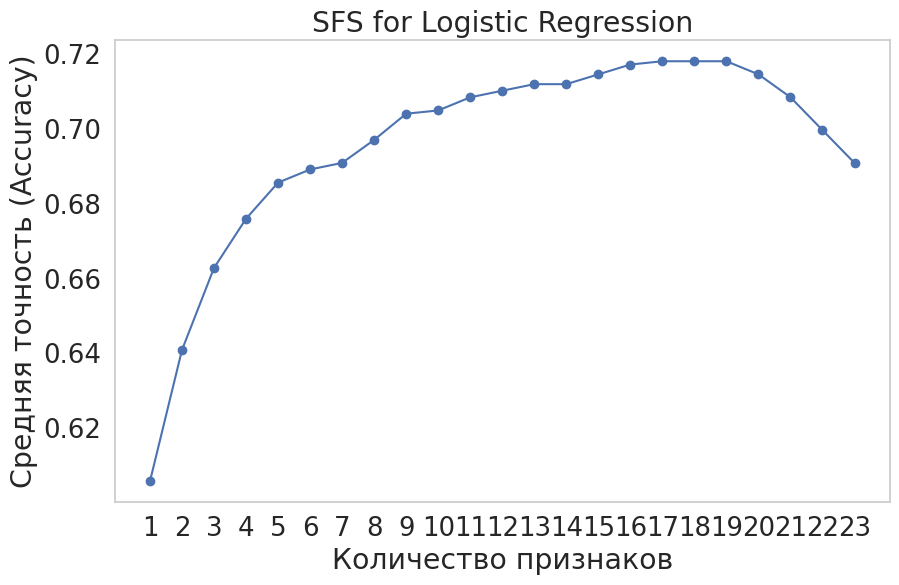


Обработка модели: Random_Forest
Итоговые отобранные признаки: ('Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes (years)', 'Hormonal Contraceptives (years)', 'IUD (years)', 'Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs:condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Hinselmann', 'Schiller')
Итоговая точность модели: 0.9060


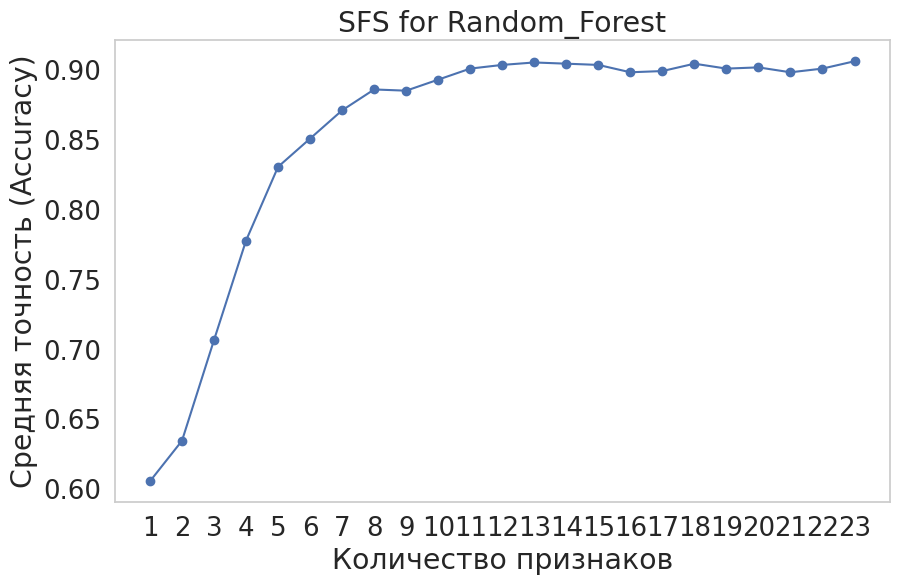


Обработка модели: AdaBoost
Итоговые отобранные признаки: ('Age', 'Number of sexual partners', 'First sexual intercourse', 'Smokes (years)', 'Hormonal Contraceptives (years)', 'IUD (years)', 'Smokes', 'Schiller')
Итоговая точность модели: 0.7349


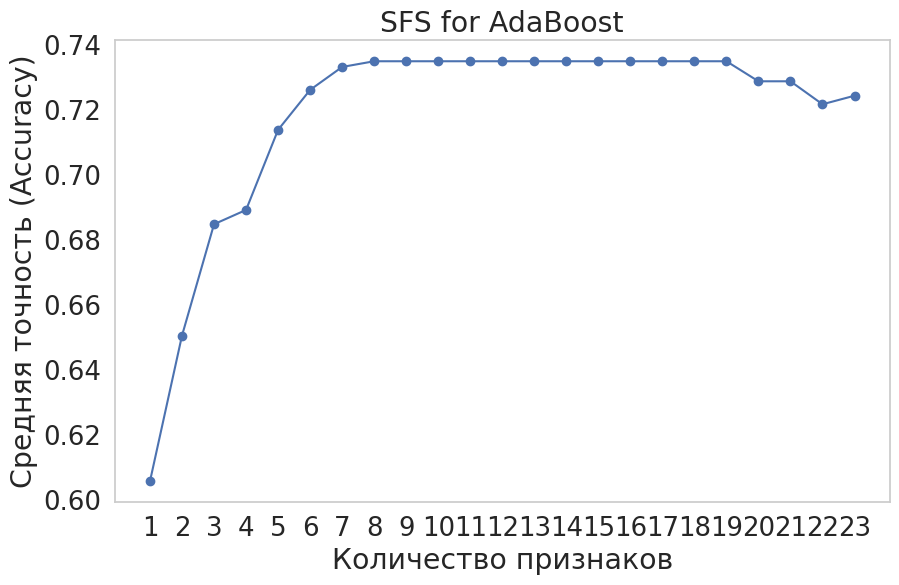


Обработка модели: Gradient Boosting
Итоговые отобранные признаки: ('Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes (years)', 'Hormonal Contraceptives (years)', 'IUD (years)', 'Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Hinselmann', 'Schiller')
Итоговая точность модели: 0.8464


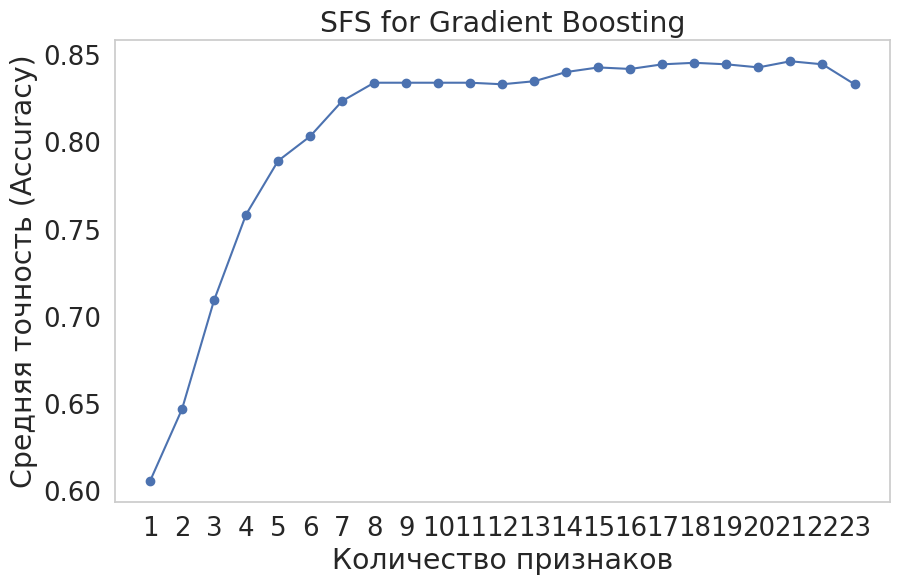


Обработка модели: XGBoost


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

#Разделим данные на тренировочные и тестовые в соотношении 70/30. Такое соотношение обусловлено размеров датасета. В качестве результатирующего выбран признак "Citology ":
x = df_for_ml_all.drop('Citology', axis=1)
y = df_for_ml_all['Citology']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
#Опишем, какие данные относятся к числовым, какие - к бинарным:

numeric_features = ['Age', 'Number of sexual partners',
                    'First sexual intercourse',
                    'Num of pregnancies',
                    'Smokes (years)',
                    'Hormonal Contraceptives (years)',
                    'IUD (years)']

binary_features = ['Smokes','Hormonal Contraceptives', 'IUD',
                   'STDs:condylomatosis', 'STDs:syphilis',
                   'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
                   'STDs:molluscum contagiosum', 'STDs:HIV', 'STDs:Hepatitis B',
                   'STDs:HPV',
                   'Dx:Cancer', 'Dx:CIN', 'Dx:HPV',
                   'Hinselmann', 'Schiller']
# Стандартизируем числовые признаки:
scaler = StandardScaler()
x_train_numeric = scaler.fit_transform(x_train[numeric_features])
x_test_numeric = scaler.transform(x_test[numeric_features])

# Преобразуем данные в улдобный вид:
x_train_numeric_df = pd.DataFrame(x_train_numeric, columns=numeric_features)
x_test_numeric_df = pd.DataFrame(x_test_numeric, columns=numeric_features)

# Бинарные признаки могут оставаться без стандартизации, поэтому оставляем их в исходном виде:
x_train_binary_df = x_train[binary_features].reset_index(drop=True)
x_test_binary_df = x_test[binary_features].reset_index(drop=True)

# Объединение стандартизированных числовых и бинарных признаков
x_train_scaled_for_sfs = pd.concat([x_train_numeric_df, x_train_binary_df], axis=1)
x_test_scaled_for_sfs = pd.concat([x_test_numeric_df, x_test_binary_df], axis=1)

# Словарь моделей
models = {

"Logistic Regression": LogisticRegression(),
"Random_Forest": RandomForestClassifier(),
"AdaBoost": AdaBoostClassifier(),
"Gradient Boosting": GradientBoostingClassifier(),
"XGBoost": XGBClassifier(),
"CatBoost": CatBoostClassifier(verbose=0),
"K-Nearest Neighbors": KNeighborsClassifier(),
"Support Vector Machine": SVC(),
"Gradient Boosting": GradientBoostingClassifier(),
"AdaBoost": AdaBoostClassifier(),
"Naive Bayes": GaussianNB(),
"Decision Tree": DecisionTreeClassifier()
}

# Результаты по моделям
results = {}

# Sequential Feature Selector (SFS) для каждой модели
for model_name, model in models.items():
    print(f"\nОбработка модели: {model_name}")

    sfs = SFS(model,
              k_features='best',  # Количество признаков
              forward=True,       # Метод forward selection
              floating=False,     # Без floating
              scoring='accuracy', # Метрика
              cv=5)               # Кросс-валидация

    sfs = sfs.fit(x_train_scaled_for_sfs, y_train)

    # Сохранение результатов
    results[model_name] = {
        "k_features": list(sfs.subsets_.keys()),
        "scores": [v['avg_score'] for v in sfs.subsets_.values()],
        "best_features": sfs.k_feature_names_,
        "best_score": sfs.k_score_
    }

    print("Итоговые отобранные признаки:", sfs.k_feature_names_)
    print(f"Итоговая точность модели: {sfs.k_score_:.4f}")

    # Визуализация для текущей модели
    plt.figure(figsize=(10, 6))
    plt.plot(results[model_name]["k_features"], results[model_name]["scores"], marker='o')
    plt.xticks(results[model_name]["k_features"])
    plt.title(f'SFS for {model_name}')
    plt.xlabel('Количество признаков')
    plt.ylabel('Средняя точность (Accuracy)')
    plt.grid()
    plt.show()

# Итоговые результаты для всех моделей
for model_name, result in results.items():
    print(f"\nРезультаты для модели: {model_name}")
    print("Лучшие признаки:", result["best_features"])
    print(f"Лучший результат (точность): {result['best_score']:.4f}")

In [ ]:
df_for_ml_sfs = df_for_ml_all[['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes (years)',
       'Hormonal Contraceptives (years)', 'IUD', 'STDs:condylomatosis',
       'STDs:pelvic inflammatory disease', 'Schiller',
       'Citology']]

#Разделим данные на тренировочные и тестовые в соотношении 70/30
x = df_for_ml_sfs.drop('Citology', axis=1)
y = df_for_ml_sfs['Citology']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

numeric_features = ['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes (years)', 'Hormonal Contraceptives (years)']

binary_features = [ 'IUD', 'Schiller',  'STDs:pelvic inflammatory disease', 'STDs:condylomatosis']

# Стандартизация числовых признаков
scaler = StandardScaler()
x_train_numeric = scaler.fit_transform(x_train[numeric_features])
x_test_numeric = scaler.transform(x_test[numeric_features])

# Преобразование в DataFrame
x_train_numeric_df = pd.DataFrame(x_train_numeric, columns=numeric_features)
x_test_numeric_df = pd.DataFrame(x_test_numeric, columns=numeric_features)

# Бинарные признаки остаются без изменений
x_train_binary_df = x_train[binary_features].reset_index(drop=True)
x_test_binary_df = x_test[binary_features].reset_index(drop=True)

# Объединение стандартизированных числовых и бинарных признаков
x_train_scaled_sfs = pd.concat([x_train_numeric_df, x_train_binary_df], axis=1)
x_test_scaled_sfs = pd.concat([x_test_numeric_df, x_test_binary_df], axis=1)

#Отберем аналогичные алгоритмы

classifiers = {
"Logistic Regression": LogisticRegression(),
"Random_Forest": RandomForestClassifier(),
"AdaBoost": AdaBoostClassifier(),
"Gradient Boosting": GradientBoostingClassifier(),
"XGBoost": XGBClassifier(),
"CatBoost": CatBoostClassifier(verbose=0),
"K-Nearest Neighbors": KNeighborsClassifier(),
"Support Vector Machine": SVC(),
"Gradient Boosting": GradientBoostingClassifier(),
"AdaBoost": AdaBoostClassifier(),
"Naive Bayes": GaussianNB(),
"Decision Tree": DecisionTreeClassifier()
}


results = {}
for name, classifier in classifiers.items():
  classifier.fit(x_train_scaled_sfs, y_train) # Обучение модели
  y_pred_sfs = classifier.predict(x_test_scaled_sfs) # Предсказание на тестовой выборке
  accuracy = accuracy_score(y_test, y_pred_sfs) # Оценка точности
  precision = precision_score(y_test, y_pred_sfs)
  recall = recall_score(y_test, y_pred_sfs)
  f1 = f1_score(y_test, y_pred_sfs)

  print(f"{name} Accuracy: {accuracy:.3f}, Precision: {precision:.3f},  Recall: {recall:.3f}, F1: {f1:.3f}")

Logistic Regression Accuracy: 0.673, Precision: 0.661,  Recall: 0.694, F1: 0.677
Random_Forest Accuracy: 0.879, Precision: 0.848,  Recall: 0.921, F1: 0.883
AdaBoost Accuracy: 0.738, Precision: 0.705,  Recall: 0.810, F1: 0.754
Gradient Boosting Accuracy: 0.822, Precision: 0.780,  Recall: 0.893, F1: 0.832
XGBoost Accuracy: 0.879, Precision: 0.848,  Recall: 0.921, F1: 0.883
CatBoost Accuracy: 0.863, Precision: 0.816,  Recall: 0.934, F1: 0.871
K-Nearest Neighbors Accuracy: 0.822, Precision: 0.748,  Recall: 0.967, F1: 0.843
Support Vector Machine Accuracy: 0.771, Precision: 0.729,  Recall: 0.855, F1: 0.787
Naive Bayes Accuracy: 0.524, Precision: 0.510,  Recall: 0.988, F1: 0.672
Decision Tree Accuracy: 0.824, Precision: 0.783,  Recall: 0.893, F1: 0.834


ДЛЯ ФАЙЛА PICKLE

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import math

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from torchvision import transforms
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             fbeta_score, roc_curve, roc_auc_score, precision_recall_curve,
                             auc, average_precision_score, classification_report)
from torchvision import transforms
import pickle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
classifier = RandomForestClassifier()
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

#Импортируем датасет
df = pd.read_csv('/content/resampled_data.csv')


#Разделим данные на тренировочные и тестовые в соотношении 70/30
x = df.drop('Citology', axis=1)
y = df['Citology']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

numeric_features = ['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes (years)', 'Hormonal Contraceptives (years)', 'IUD (years)' ]

binary_features = ['Hormonal Contraceptives',  'Smokes', 'IUD', 'Schiller', 'STDs:HIV', 'STDs:condylomatosis']


preprocessor = ColumnTransformer(
transformers=[
('num', StandardScaler(), numeric_features),
('bin', 'passthrough', binary_features)])


# Создание пайплайна
pipeline = Pipeline(steps=[
('preprocessor', preprocessor), # Применение препроцессинга
('classifier', RandomForestClassifier()) # Модель классификации
])


# Обучение модели
pipeline.fit(x_train, y_train)

with open('model_with_scaler.pkl', 'wb') as file:
  pickle.dump(pipeline, file)

In [ ]:
with open('model_with_scaler.pkl', 'rb') as file:
  model = pickle.load(file)

input_data = pd.DataFrame(columns=['Age', 'Number of sexual partners', 'First sexual intercourse',  'Num of pregnancies', 'STDs:condylomatosis',
       'Smokes', 'Smokes (years)', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)',
        'IUD',  'IUD (years)', 'STDs:HIV', 'Schiller'])
input_data.loc[0] = [28, 1, 0, 1, 1, 'нет', 0, 'нет', 0, 'нет', 0, 0, 1]
input_data = input_data.replace({'да': 1, 'нет': 0})
predicted_class = model.predict(input_data)
probabilities = model.predict_proba(input_data)

results_df = pd.DataFrame({
'Оценка риска': np.where(predicted_class == 1, 'Выше среднего', 'Ниже среднего'),
'Вероятность развития РШМ(в %)': np.where(predicted_class == 1, probabilities[:, 1] * 100, probabilities[:, 1] * 100)# Берем вероятность для класса 1
})

# Форматирование DataFrame
results_df['Вероятность развития РШМ(в %)'] = results_df['Вероятность развития РШМ(в %)'].round(2) # Округляем до двух знаков

# Вывод результатов
print(results_df)

    Оценка риска  Вероятность развития РШМ(в %)
0  Выше среднего                        59.0000


ТЕСТЫ И ПРОБЫ